In [1]:
%matplotlib inline
import time
import numpy as np
import xesmf as xe
import xarray as xr
import netCDF4 as nc
import cmocean as cm
import cartopy.crs as ccrs
import matplotlib.ticker
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import warnings
warnings.filterwarnings('ignore')

In [2]:
g = 9.8
rho0 = 1035.0
m2_period = 236 # in hr

In [3]:
tpxo = xr.open_dataset('/g/data/nm03/TPXO/h_tpxo9.v1.nc')
tpgd = xr.open_dataset('/g/data/nm03/TPXO/grid_tpxo9.nc')
pha_tpxo = (tpxo.hp.isel({'nc':0}).transpose()-180) /180 *np.pi +13*np.pi/16
amp_tpxo = tpxo.ha.isel({'nc':0}).transpose()
lon_tpxo = np.array(tpgd.lon_z.transpose())
lat_tpxo = np.array(tpgd.lat_z.transpose())
hz_tpxo  = np.array(tpgd.hz.transpose())
hu_tpxo  = np.array(tpgd.hu.transpose())
hv_tpxo  = np.array(tpgd.hv.transpose())
ny, nx   = np.array(tpgd.ny), np.array(tpgd.nx)

0.3.0


In [4]:
lat_tpxo.shape

(1081, 2160)

### Construct TPXO elevation $\eta$

In [5]:
t_12cyc = np.arange(m2_period)
nt_tpxo = t_12cyc.size
omega_m2 = np.full((nt_tpxo,ny.size,nx.size),(2*np.pi/(12.4206014)))
elev_tpxo = np.array(amp_tpxo)[None,:,:] * np.cos(omega_m2 * t_12cyc[:,None,None] - np.array(pha_tpxo)[None,:,:])

### Construct TPXO elevation

In [6]:
beta = 0.094
eta_sal = beta * elev_tpxo

In [7]:
love = 0.693
eta_eq = love * 0.242334 * np.cos(np.pi/180*lat_tpxo[None,:,:])**2 * np.exp(-1j*(omega_m2 * t_12cyc[:,None,None]+2*np.pi/180*lon_tpxo[None,:,:]))

In [8]:
eta = eta_sal + eta_eq

In [9]:
tpxo_vel = xr.open_dataset('/g/data/nm03/TPXO/u_tpxo9.v1.nc')
ua_tpxo = np.array(tpxo_vel.ua.isel({'nc':0}).transpose()/100)
va_tpxo = np.array(tpxo_vel.va.isel({'nc':0}).transpose()/100)
up_tpxo = np.array((tpxo_vel.up.isel({'nc':0}).transpose() - 180) /180 *np.pi +13*np.pi/16)
vp_tpxo = np.array((tpxo_vel.vp.isel({'nc':0}).transpose() - 180) /180 *np.pi +13*np.pi/16)
lon_u_tpxo = np.array(tpxo_vel.lon_u.transpose())
lat_u_tpxo = np.array(tpxo_vel.lat_u.transpose())
lon_v_tpxo = np.array(tpxo_vel.lon_v.transpose())
lat_v_tpxo = np.array(tpxo_vel.lat_v.transpose())

In [10]:
u_tpxo = ua_tpxo[None,:,:] * np.cos(omega_m2 * t_12cyc[:,None,None] - up_tpxo[None,:,:]) * hu_tpxo[None,:,:]
v_tpxo = va_tpxo[None,:,:] * np.cos(omega_m2 * t_12cyc[:,None,None] - vp_tpxo[None,:,:]) * hv_tpxo[None,:,:]

In [11]:
eta.shape

(236, 1081, 2160)

In [12]:
def get_delta_lon(lat):

    # compute the distance in km at this lon and lat
    delta_lon = 2 * np.pi * (6371 * np.cos(lat*np.pi/180)) / 360
    
    return delta_lon

In [13]:
delta_lon = get_delta_lon(lat_tpxo)*1e+3
dlon = (delta_lon[:,1:]+ delta_lon[:,:-1])/2
deta_dlon = (eta[:,:,1:]-eta[:,:,:-1])/dlon[None,:,:]
# du_dlon = (u_tpxo[:,:,1:]-u_tpxo[:,:,:-1])/dlon[None,:,:]
lon_u_mid = (lon_tpxo[:,1:] + lon_tpxo[:,:-1])/2
lat_u_mid = (lat_tpxo[:,1:] + lat_tpxo[:,:-1])/2

In [14]:
delta_lat = np.full((ny.size,nx.size), 1 * np.pi * 6371 / 180*1e+3)
dlat = (delta_lat[1:,:]+ delta_lat[:-1,:])/2
deta_dlat = (eta[:,1:,:]-eta[:,:-1,:])/dlat[None,:,:]
# dv_dlat = (v_tpxo[:,1:,:]-v_tpxo[:,:-1,:])/dlat[None,:,:]
lon_v_mid = (lon_tpxo[1:,:] + lon_tpxo[:-1,:])/2
lat_v_mid = (lat_tpxo[1:,:] + lat_tpxo[:-1,:])/2

In [15]:
ds_u_mid = xr.Dataset(data_vars={'deta_dlon': (('nt','ny','nx'), deta_dlon),
                                 # 'du_dlon': (('ny','nx'), du_dlon),
                                },
                      coords={'lon': (('ny', 'nx'), lon_u_mid), 
                              'lat': (('ny', 'nx'), lat_u_mid)})

ds_v_mid = xr.Dataset(data_vars={'deta_dlat': (('nt','ny','nx'), deta_dlat),
                                 # 'dv_dlat': (('ny','nx'), dv_dlat),
                                },
                      coords={'lon': (('ny', 'nx'), lon_v_mid), 
                              'lat': (('ny', 'nx'), lat_v_mid)})

ds_grid_u = xr.Dataset({"lat": (["ny","nx"], lat_u_tpxo),
                        "lon": (["ny","nx"], lon_u_tpxo)})

ds_grid_v = xr.Dataset({"lat": (["ny","nx"], lat_v_tpxo),
                        "lon": (["ny","nx"], lon_v_tpxo)})

regridder_um_u = xe.Regridder(ds_u_mid, ds_grid_u, "bilinear", extrap_method="inverse_dist")
regridder_vm_v = xe.Regridder(ds_v_mid, ds_grid_v, "bilinear", extrap_method="inverse_dist")
ds_detadx_u = regridder_um_u(ds_u_mid)
ds_detady_v = regridder_vm_v(ds_v_mid)

In [16]:
u_grd_eta = u_tpxo * np.array(ds_detadx_u['deta_dlon'])
v_grd_eta = v_tpxo * np.array(ds_detady_v['deta_dlat'])
ds_u_grad = xr.Dataset(data_vars={'u_grd_eta': (('nt','ny','nx'), u_grd_eta),
                                  'u_tpxo': (('nt','ny','nx'), u_tpxo)},
                       coords={'lon': (('ny', 'nx'), lon_u_tpxo), 
                               'lat': (('ny', 'nx'), lat_u_tpxo)})
ds_v_grad = xr.Dataset(data_vars={'v_grd_eta': (('nt','ny','nx'), v_grd_eta),
                                  'v_tpxo': (('nt','ny','nx'), v_tpxo)},
                       coords={'lon': (('ny', 'nx'), lon_v_tpxo), 
                               'lat': (('ny', 'nx'), lat_v_tpxo)})
ds_grid_z = xr.Dataset({"lat": (["ny","nx"], lat_tpxo),
                        "lon": (["ny","nx"], lon_tpxo)})
regridder_u2z = xe.Regridder(ds_u_grad, ds_grid_z, "bilinear", extrap_method="inverse_dist")
regridder_v2z = xe.Regridder(ds_v_grad, ds_grid_z, "bilinear", extrap_method="inverse_dist")
ds_u2z_grad = regridder_u2z(ds_u_grad)
ds_v2z_grad = regridder_v2z(ds_v_grad)

In [17]:
W = np.nanmean(ds_u2z_grad['u_grd_eta'] + ds_v2z_grad['v_grd_eta'], axis=0) * g * rho0

In [18]:
Px = np.nanmean(ds_u2z_grad['u_tpxo']*elev_tpxo, axis=0)
Py = np.nanmean(ds_v2z_grad['v_tpxo']*elev_tpxo, axis=0)

In [19]:
dPx_dlon = (Px[:,1:]-Px[:,:-1])/dlon[:,:]
dPy_dlat = (Py[1:,:]-Py[:-1,:])/dlat[:,:]

In [20]:
ds_u_mid = xr.Dataset(data_vars={'dPx_dlon': (('ny','nx'), dPx_dlon),
                                },
                      coords={'lon': (('ny', 'nx'), lon_u_mid), 
                              'lat': (('ny', 'nx'), lat_u_mid)})

ds_v_mid = xr.Dataset(data_vars={'dPy_dlat': (('ny','nx'), dPy_dlat),
                                },
                      coords={'lon': (('ny', 'nx'), lon_v_mid), 
                              'lat': (('ny', 'nx'), lat_v_mid)})

regridder_u2z_gradP = xe.Regridder(ds_u_mid, ds_grid_z, "bilinear", extrap_method="inverse_dist")
regridder_v2z_gradP = xe.Regridder(ds_v_mid, ds_grid_z, "bilinear", extrap_method="inverse_dist")
ds_u2z_gradP = regridder_u2z_gradP(ds_u_mid)
ds_v2z_gradP = regridder_v2z_gradP(ds_v_mid)

In [21]:
gradP = (ds_u2z_gradP['dPx_dlon'] + ds_v2z_gradP['dPy_dlat']) * g * rho0

In [22]:
D = W - gradP

### Convert D to MOM6 grid

In [23]:
file_stat = '/g/data/nm03/lxy581/archive/tides_025_SAL_JSL_masked/output003/ocean_static.nc'
stat  = xr.open_dataset(file_stat)
yh, xh = stat.yh, stat.xh
depth  = stat['deptho']
geolat = stat['geolat']
geolon = stat['geolon']
geolon_u = stat['geolon_u']
geolat_u = stat['geolat_u']
geolon_v = stat['geolon_v']
geolat_v = stat['geolat_v']
area   = stat['areacello']
fac_dep = xr.where(depth > 1000, 1, np.nan) 
fac_lat = xr.where((geolat < 75) & (geolat > -75), 1, np.nan)
fac = np.array(fac_dep) * np.array(fac_lat)

In [24]:
topog = xr.open_dataset('/home/581/lxy581/tidal_param/MOM6-examples/ocean_only/tides_025/INPUT/ocean_topog.nc')
depth = topog.depth
depth_z = np.array(depth)
depth_z[depth_z==0]=np.nan
depth_da = xr.Dataset(data_vars={'depth_xr': (('yh','xh'), depth_z),
                                }, 
                      coords={'lon': (('yh', 'xh'), np.array(geolon)),
                              'lat': (('yh', 'xh'), np.array(geolat))})
land = xr.where(np.isnan(depth_da.depth_xr[:,:].rename('land')), 1, np.nan)

In [25]:
ds_D_tpxo = xr.Dataset(data_vars={'dissip': (('ny','nx'), np.array(D))},
                       coords={'lon': (('ny', 'nx'), lon_tpxo), 
                               'lat': (('ny', 'nx'), lat_tpxo)})
ds_mom6_grid = xr.Dataset({"lat": (["yh","xh"], np.array(geolat)),
                           "lon": (["yh","xh"], np.array(geolon))})
regridder_dissip = xe.Regridder(ds_D_tpxo, ds_mom6_grid, "bilinear", extrap_method="inverse_dist")
ds_D_mom6 = regridder_dissip(ds_D_tpxo)
TPXO_dissip = np.array(ds_D_mom6['dissip'])
global_dissip  = np.nansum(TPXO_dissip * np.array(area)) / 1e+12

In [36]:
TPXO_dissip = np.abs(np.array(ds_D_mom6['dissip'])) * fac_lat
# print(np.nanmin(TPXO_dissip))
# print(np.nanmax(TPXO_dissip))
area_dissip = TPXO_dissip * np.array(area)
global_dissip  = np.nansum(area_dissip) / 1e+12
deep_dissip = np.nansum(area_dissip*fac_dep) / 1e+12
print('Global M2 tidal energy dissipation: %.1fTW'%global_dissip)
print('Open ocean dissipation fraction: %d%%'%(deep_dissip/global_dissip*100))

Global M2 tidal energy dissipation: 2.1TW
Open ocean dissipation fraction: 56%


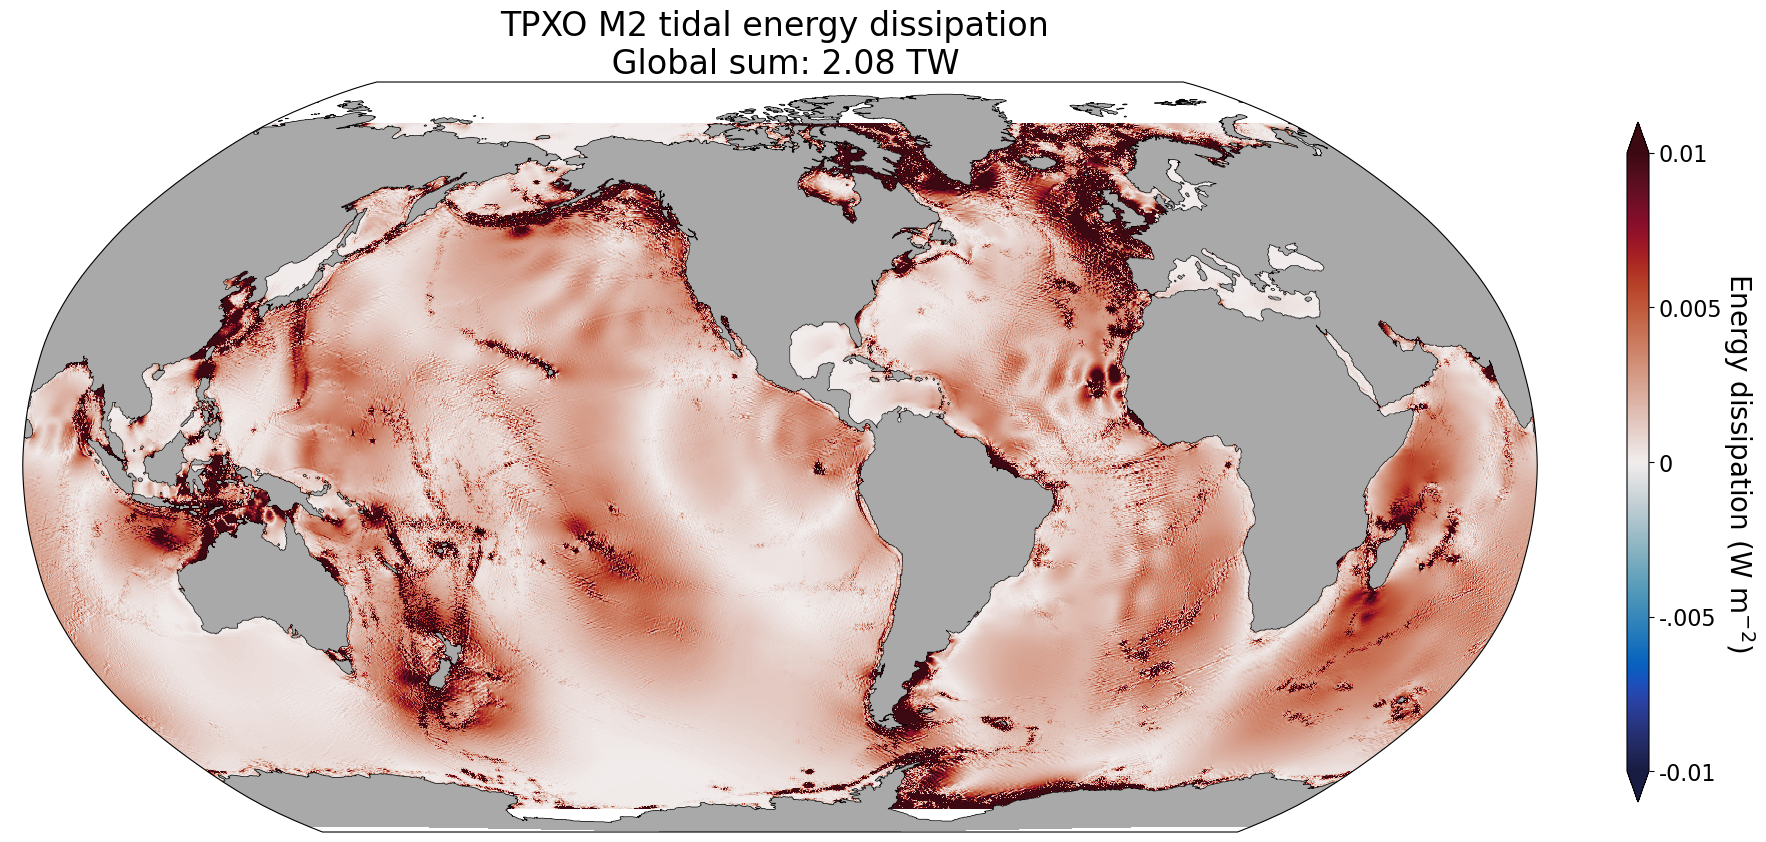

In [37]:
varlist = ['TPXO_dissip']
title   = ['TPXO M2 tidal energy dissipation \n Global sum: %.2f TW'%(global_dissip)]

tick_locs = np.array([-0.01,-0.005,0,0.005,0.01])
tick_labels = np.array(["-0.01","-.005","0","0.005","0.01"])

fig = plt.figure(figsize=(22, 10))
axs = []

gridsubs = gridspec.GridSpec(1,1)
for gs in gridsubs:
    axs.append(plt.subplot(gs))

for I, (ax, var) in enumerate(zip(axs, varlist)):

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=-100))
    # Add model land mask
    land.plot.contourf(ax=ax, x='lon', y='lat', colors='darkgrey', zorder=2, transform=ccrs.PlateCarree(), add_colorbar=False)
    # Add model coastline
    land.fillna(0).plot.contour(ax=ax, x='lon', y='lat', colors='k', levels=[0, 1], transform=ccrs.PlateCarree(), add_colorbar=False, linewidths=0.5)

    p1 = ax.pcolormesh(geolon, geolat, globals()[var], transform=ccrs.PlateCarree(), cmap=cm.cm.balance, vmin=-0.01, vmax=0.01)
    # p1 = ax.pcolormesh(geolon, geolat, globals()[var], transform=ccrs.PlateCarree(), cmap=cm.cm.deep, norm=LogNorm(vmin=1e-4, vmax=1e-2))
    plt.title(title[I],fontsize=24)
  
    if I==0:
        ax_cb = plt.axes([0.86, 0.13, 0.01, 0.68])
    
    cb1 = plt.colorbar(p1, cax=ax_cb, orientation='vertical', extend='both')
    cb1.ax.set_ylabel('Energy dissipation (W m$^{-2}$)',fontsize=20,rotation=270,labelpad=25);
    cb1.ax.tick_params(labelsize=16)
    cb1.locator   = matplotlib.ticker.FixedLocator(tick_locs)
    cb1.formatter = matplotlib.ticker.FixedFormatter(tick_labels)

    if I==0:
        ax.set_position([0.1,0.1,0.75,0.75])
        
plt.savefig('/g/data/nm03/lxy581/exps_figs/TPXO_M2_dissip_lin.png', dpi=300, bbox_inches='tight')